In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px
from scipy import ndimage
from pickle import load

In [2]:
from models.Hang2020_mod import Hang2020, spectral_network, spatial_network

In [3]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [4]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Load mean and std values of training dataset

In [5]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

### Load scalers for parameters

In [6]:
parameters_scalers = dict()
parameters_scalers['P'] = load((open(os.path.join(train_data_directory, 'standard_scaler_P.pkl'), 'rb')))
parameters_scalers['K'] = load((open(os.path.join(train_data_directory, 'standard_scaler_K.pkl'), 'rb')))
parameters_scalers['Mg'] = load((open(os.path.join(train_data_directory, 'standard_scaler_Mg.pkl'), 'rb')))
parameters_scalers['pH'] = load((open(os.path.join(train_data_directory, 'standard_scaler_pH.pkl'), 'rb')))

In [7]:
parameters_scalers['P'].mean_

array([70.30265589])

### Dataset definition

In [8]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False, parameters_scalers=None):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.transform = transform  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

        if parameters_scalers is not None:
            self.scaler_P = parameters_scalers['P']
            self.scaler_K = parameters_scalers['K']
            self.scaler_Mg = parameters_scalers['Mg']
            self.scaler_pH = parameters_scalers['pH']
        else:
            self.scaler_P = None
            self.scaler_K = None
            self.scaler_Mg = None
            self.scaler_pH = None

    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2

        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)

        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)

        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(
                300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']
            
            if self.scaler_P is not None:
                assert self.scaler_K is not None
                assert self.scaler_Mg is not None
                assert self.scaler_pH is not None
                
                P_gt = self.scaler_P.transform(np.array(P_gt).reshape(1, -1))[0][0]
                K_gt = self.scaler_K.transform(np.array(K_gt).reshape(1, -1))[0][0]
                Mg_gt = self.scaler_Mg.transform(np.array(Mg_gt).reshape(1, -1))[0][0]
                pH_gt = self.scaler_pH.transform(np.array(pH_gt).reshape(1, -1))[0][0]
                

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [9]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), True, means, stds, train_transforms=True, parameters_scalers=parameters_scalers)

In [10]:
train_dataset, validation_dataset = random_split(train_data_whole, [1000, 732], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

### Model Definition

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
BATCH_SIZE = 12
EPOCHS = 300

In [13]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

In [16]:
model = Hang2020(bands=150, classes=1, pretrained=True).to(device)

### Overfitting on single batch of data

In [17]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [18]:
train_data_single_batch = next(iter(train_dataloader))

In [19]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [20]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [21]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float)) # we are interested in final values (from las attention layer)

/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [22]:
output

tensor([[0.1029],
        [0.0324],
        [0.0942],
        [0.1080],
        [0.0981],
        [0.0924],
        [0.0375],
        [0.0986],
        [0.1041],
        [0.0822],
        [0.0312],
        [0.0919]], device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
output.shape

torch.Size([12, 1])

In [24]:
stacked_gt = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device)
stacked_gt

tensor([[-1.3833],
        [-1.1392],
        [ 0.8170],
        [ 0.8712],
        [-1.4138],
        [-0.1187],
        [-1.3155],
        [-0.1357],
        [ 0.8780],
        [-0.7053],
        [ 1.0068],
        [-0.2306]], device='cuda:0', dtype=torch.float64)

In [25]:
loss_func(output, stacked_gt)

tensor(0.9314, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

#### Sprawdzenie czy inwersja skalowania działa właściwie

In [26]:
gt_df = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [27]:
train_data_single_batch['sample_index']

tensor([1731, 1176, 1101,  520,   98,  400, 1148,  101, 1167, 1558, 1606, 1662])

In [28]:
gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ 29.5],
       [ 36.7],
       [ 94.4],
       [ 96. ],
       [ 28.6],
       [ 66.8],
       [ 31.5],
       [ 66.3],
       [ 96.2],
       [ 49.5],
       [100. ],
       [ 63.5]])

In [29]:
scaler = getattr(train_dataset.dataset, f'scaler_P')
scaler

StandardScaler()

In [30]:
scaler.inverse_transform(stacked_gt.cpu())

array([[ 29.5],
       [ 36.7],
       [ 94.4],
       [ 96. ],
       [ 28.6],
       [ 66.8],
       [ 31.5],
       [ 66.3],
       [ 96.2],
       [ 49.5],
       [100. ],
       [ 63.5]])

In [31]:
scaler.inverse_transform(stacked_gt.cpu()) == gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

#### Właściwa pętla overfit

In [32]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)
scaler = getattr(train_dataset.dataset, f'scaler_P')

model = Hang2020(bands=150, classes=1, pretrained=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
model.train()

for epoch in range(301):

    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()
    
    output_cpu_inversed = scaler.inverse_transform(output_cpu)
    stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

    # Calculate MSE for each class
    mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}, MSE from unscaled values: {mse_inversed}')

epoch: 0, loss: 0.849164605140686, MSE: [0.84916455], MSE from unscaled values: [738.79834]
epoch: 10, loss: 0.2709139287471771, MSE: [0.27091393], MSE from unscaled values: [235.70314]
epoch: 20, loss: 0.218845933675766, MSE: [0.21884595], MSE from unscaled values: [190.40242]
epoch: 30, loss: 0.16382962465286255, MSE: [0.16382961], MSE from unscaled values: [142.5366]
epoch: 40, loss: 0.0937298983335495, MSE: [0.09372989], MSE from unscaled values: [81.5478]
epoch: 50, loss: 0.09154470264911652, MSE: [0.09154469], MSE from unscaled values: [79.64661]
epoch: 60, loss: 0.04959078133106232, MSE: [0.04959078], MSE from unscaled values: [43.14546]
epoch: 70, loss: 0.01129663735628128, MSE: [0.01129664], MSE from unscaled values: [9.828408]
epoch: 80, loss: 0.0039753420278429985, MSE: [0.00397534], MSE from unscaled values: [3.4586656]
epoch: 90, loss: 0.0008636377169750631, MSE: [0.00086364], MSE from unscaled values: [0.7513898]
epoch: 100, loss: 0.00030506521579809487, MSE: [0.00030507]

#### Testing models

In [203]:
#Download weights for resnet18
url = "https://download.pytorch.org/models/resnet18-f37072fd.pth"
state = torch.utils.model_zoo.load_url(url)

In [214]:
model = spectral_network(bands=150, classes=1, pretrained=True)

In [215]:
model

spectral_network(
  (conv1): conv_module(
    (resnet_model): Sequential(
      (0): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [216]:
# sanity check if resnet weights in conv1 module were correctly loaded
torch.equal(model.conv1.resnet_model[1].weight, state['bn1.weight'])

True

In [217]:
model(train_data_single_batch['image'])

[tensor([[0.0046],
         [0.0047],
         [0.0146],
         [0.0157],
         [0.0042],
         [0.0061],
         [0.0051],
         [0.0046],
         [0.0048],
         [0.0131],
         [0.0047],
         [0.0122]], grad_fn=<AddmmBackward0>),
 tensor([[0.0535],
         [0.0510],
         [0.0434],
         [0.0514],
         [0.0525],
         [0.0520],
         [0.0519],
         [0.0543],
         [0.0522],
         [0.0551],
         [0.0521],
         [0.0529]], grad_fn=<AddmmBackward0>),
 tensor([[0.0240],
         [0.1118],
         [0.0501],
         [0.0542],
         [0.0328],
         [0.1285],
         [0.0754],
         [0.0231],
         [0.0412],
         [0.0983],
         [0.0378],
         [0.1808]], grad_fn=<AddmmBackward0>)]

In [223]:
model_spatial = spatial_network(bands=150, classes=1, pretrained=True)

In [225]:
# sanity check if resnet weights in conv1 module were correctly loaded
torch.equal(model_spatial.conv1.resnet_model[1].weight, state['bn1.weight'])

True

In [224]:
model_spatial(train_data_single_batch['image'])

[tensor([[ 0.1896],
         [ 0.2246],
         [ 0.1130],
         [ 0.3667],
         [ 0.2196],
         [ 0.5353],
         [ 0.2221],
         [ 0.2024],
         [ 0.5038],
         [-0.0584],
         [ 0.4996],
         [ 0.0577]], grad_fn=<AddmmBackward0>),
 tensor([[0.1124],
         [0.1075],
         [0.1057],
         [0.1022],
         [0.0943],
         [0.1809],
         [0.1300],
         [0.1173],
         [0.1011],
         [0.0598],
         [0.1057],
         [0.1255]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0662],
         [-0.0283],
         [-0.0368],
         [-0.1373],
         [-0.0638],
         [-0.0842],
         [-0.0955],
         [-0.0538],
         [-0.0973],
         [-0.2037],
         [-0.0509],
         [-0.1636]], grad_fn=<AddmmBackward0>)]

### Training Definition

In [14]:
parameter = 'K'

In [15]:
save_name = "checkpoint_state_dict_Hang2020_23_05_2022_Single_Parameter_Scaled_{}".format(parameter)
save_name

'checkpoint_state_dict_Hang2020_23_05_2022_Single_Parameter_Scaled_K'

In [16]:
model_name = save_name+'.pth'

In [17]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [18]:
model = Hang2020(bands=150, classes=1, pretrained=True).to(device)

In [19]:
wandb.watch(model, log="None", log_freq=20)

[]

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [21]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [23]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [24]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(batch_data['P'].unsqueeze(dim=0).permute(1, 0), dtype=torch.float))

In [25]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 8.30E-05


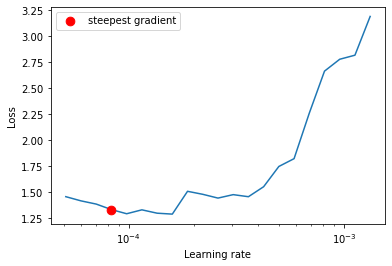

In [26]:
lr_finder.plot()
lr_finder.reset()

In [35]:
8.30E-05

8.3e-05

### Training

In [22]:
patience_scheduler_overfit = 8
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [23]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

#### Logging training informations for W&B

In [24]:
config = wandb.config
config.model = 'ResHang2020'
config.optimizer = 'AdamW'
config.loss_function = 'MSELoss'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = patience_scheduler_overfit
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'ResHang2020 - Hang2020 with modified conv layer to pretrained (on Imagenet) ResNet blocks. Parameter {} SCALED Training split:1000, Validation: 732. Scaled predicted variable'.format(parameter)
config.parameter = parameter

In [25]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [26]:
scaler = getattr(train_dataset.dataset, f'scaler_{parameter}')

for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    mse_inversed_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
#         stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
#             0, 1).to(device, dtype=torch.float)
        stacked_gt_device = train_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        output_cpu_inversed = scaler.inverse_transform(output_cpu)
        stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
        mse_train_list.append(mse)
        mse_inversed_train_list.append(mse_inversed)
        

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_{}'.format(parameter)] = mse[0]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    avg_train_mse_inversed = torch.as_tensor(
        np.array(mse_inversed_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}, train MSE from unscaled values: {avg_train_mse_inversed}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_{}'.format(parameter): avg_train_mse_inversed[0]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        mse_inversed_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
#             stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
#                 0, 1).to(device, dtype=torch.float)
            stacked_gt_device =  val_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()
            
            output_cpu_inversed = scaler.inverse_transform(output_cpu)
            stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
            mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
            mse_inversed_val_list.append(mse_inversed)


        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        avg_val_mse_inversed = torch.as_tensor(
            np.array(mse_inversed_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}, validation MSE from unscaled values: {avg_val_mse_inversed}')
        # using MSE from inversed values in W&B logger to make it compatible with previous runs in W&B
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_validation_MSE_{}'.format(parameter): avg_val_mse_inversed[0]}) 

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/83 [00:00<?, ?it/s]

/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0, LR: 0.01, train loss: 1.046574354171753, train MSE: [1.0465744733810425], train MSE from unscaled values: [4006.712646484375]


epoch 0 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 0, validation loss: 1.1335978507995605, validation MSE: [1.13359797000885], validation MSE from unscaled values: [4339.8740234375]
Validation loss decreased (inf --> 1.133598).  Saving model ...


epoch 1 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 1.021488904953003, train MSE: [1.0214890241622925], train MSE from unscaled values: [3910.675537109375]


epoch 1 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 1, validation loss: 1.076127290725708, validation MSE: [1.076127290725708], validation MSE from unscaled values: [4119.85302734375]
Validation loss decreased (1.133598 --> 1.076127).  Saving model ...


epoch 2 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 1.0084900856018066, train MSE: [1.0084900856018066], train MSE from unscaled values: [3860.910400390625]


epoch 2 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 2, validation loss: 0.9453424215316772, validation MSE: [0.9453422427177429], validation MSE from unscaled values: [3619.155517578125]
Validation loss decreased (1.076127 --> 0.945342).  Saving model ...


epoch 3 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 1.024133324623108, train MSE: [1.024133324623108], train MSE from unscaled values: [3920.798828125]


epoch 3 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 3, validation loss: 0.9293668866157532, validation MSE: [0.929366946220398], validation MSE from unscaled values: [3557.99462890625]
Validation loss decreased (0.945342 --> 0.929367).  Saving model ...


epoch 4 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 1.0110658407211304, train MSE: [1.0110658407211304], train MSE from unscaled values: [3870.770751953125]


epoch 4 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 4, validation loss: 0.9484047293663025, validation MSE: [0.9484047889709473], validation MSE from unscaled values: [3630.87939453125]
EarlyStopping counter: 1 out of 19


epoch 5 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 1.001538872718811, train MSE: [1.001538872718811], train MSE from unscaled values: [3834.298095703125]


epoch 5 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 5, validation loss: 0.9419974684715271, validation MSE: [0.9419975280761719], validation MSE from unscaled values: [3606.349609375]
EarlyStopping counter: 2 out of 19


epoch 6 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 0.9972622990608215, train MSE: [0.9972623586654663], train MSE from unscaled values: [3817.925537109375]


epoch 6 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 6, validation loss: 0.9414393901824951, validation MSE: [0.9414393305778503], validation MSE from unscaled values: [3604.212890625]
EarlyStopping counter: 3 out of 19


epoch 7 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 0.9989733695983887, train MSE: [0.9989733695983887], train MSE from unscaled values: [3824.476318359375]


epoch 7 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 7, validation loss: 1.0507632493972778, validation MSE: [1.0507633686065674], validation MSE from unscaled values: [4022.749267578125]
EarlyStopping counter: 4 out of 19


epoch 8 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 1.0106916427612305, train MSE: [1.0106916427612305], train MSE from unscaled values: [3869.33837890625]


epoch 8 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 8, validation loss: 0.9072069525718689, validation MSE: [0.9072070121765137], validation MSE from unscaled values: [3473.157470703125]
Validation loss decreased (0.929367 --> 0.907207).  Saving model ...


epoch 9 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 0.9921367168426514, train MSE: [0.9921366572380066], train MSE from unscaled values: [3798.302734375]


epoch 9 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 9, validation loss: 0.9033560156822205, validation MSE: [0.9033560752868652], validation MSE from unscaled values: [3458.414306640625]
Validation loss decreased (0.907207 --> 0.903356).  Saving model ...


epoch 10 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 0.9640514254570007, train MSE: [0.9640514254570007], train MSE from unscaled values: [3690.78125]


epoch 10 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 10, validation loss: 0.9328551888465881, validation MSE: [0.9328552484512329], validation MSE from unscaled values: [3571.34912109375]
EarlyStopping counter: 1 out of 19


epoch 11 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 0.9854252338409424, train MSE: [0.9854252934455872], train MSE from unscaled values: [3772.60888671875]


epoch 11 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 11, validation loss: 0.9661369323730469, validation MSE: [0.9661369919776917], validation MSE from unscaled values: [3698.765625]
EarlyStopping counter: 2 out of 19


epoch 12 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 12, LR: 0.01, train loss: 0.9920668005943298, train MSE: [0.9920668005943298], train MSE from unscaled values: [3798.034912109375]


epoch 12 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 12, validation loss: 0.9281411170959473, validation MSE: [0.9281411170959473], validation MSE from unscaled values: [3553.302001953125]
EarlyStopping counter: 3 out of 19


epoch 13 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 13, LR: 0.01, train loss: 0.9796416163444519, train MSE: [0.9796416759490967], train MSE from unscaled values: [3750.466796875]


epoch 13 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 13, validation loss: 0.9090480804443359, validation MSE: [0.9090481400489807], validation MSE from unscaled values: [3480.2060546875]
EarlyStopping counter: 4 out of 19


epoch 14 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 14, LR: 0.01, train loss: 0.9630191922187805, train MSE: [0.9630191326141357], train MSE from unscaled values: [3686.829345703125]


epoch 14 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 14, validation loss: 0.9016998410224915, validation MSE: [0.9016998410224915], validation MSE from unscaled values: [3452.07373046875]
Validation loss decreased (0.903356 --> 0.901700).  Saving model ...


epoch 15 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 15, LR: 0.01, train loss: 0.970344603061676, train MSE: [0.9703445434570312], train MSE from unscaled values: [3714.874267578125]


epoch 15 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 15, validation loss: 0.9212360978126526, validation MSE: [0.9212360978126526], validation MSE from unscaled values: [3526.8662109375]
EarlyStopping counter: 1 out of 19


epoch 16 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 16, LR: 0.01, train loss: 0.9649609923362732, train MSE: [0.9649609327316284], train MSE from unscaled values: [3694.26318359375]


epoch 16 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 16, validation loss: 0.9337701797485352, validation MSE: [0.9337702393531799], validation MSE from unscaled values: [3574.8525390625]
EarlyStopping counter: 2 out of 19


epoch 17 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 17, LR: 0.01, train loss: 0.9673035144805908, train MSE: [0.967303454875946], train MSE from unscaled values: [3703.231201171875]


epoch 17 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 17, validation loss: 0.9277696013450623, validation MSE: [0.9277696013450623], validation MSE from unscaled values: [3551.879638671875]
EarlyStopping counter: 3 out of 19


epoch 18 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 18, LR: 0.01, train loss: 0.9635419249534607, train MSE: [0.9635419845581055], train MSE from unscaled values: [3688.83056640625]


epoch 18 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 18, validation loss: 0.9779114723205566, validation MSE: [0.9779115319252014], validation MSE from unscaled values: [3743.84326171875]
EarlyStopping counter: 4 out of 19


epoch 19 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 19, LR: 0.01, train loss: 0.966590404510498, train MSE: [0.966590404510498], train MSE from unscaled values: [3700.501220703125]


epoch 19 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 19, validation loss: 0.9034366011619568, validation MSE: [0.9034366011619568], validation MSE from unscaled values: [3458.722900390625]
EarlyStopping counter: 5 out of 19


epoch 20 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 20, LR: 0.01, train loss: 0.9360606670379639, train MSE: [0.9360607266426086], train MSE from unscaled values: [3583.620849609375]


epoch 20 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 20, validation loss: 0.9426589012145996, validation MSE: [0.9426588416099548], validation MSE from unscaled values: [3608.881591796875]
EarlyStopping counter: 6 out of 19


epoch 21 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 21, LR: 0.01, train loss: 0.9586699604988098, train MSE: [0.958669900894165], train MSE from unscaled values: [3670.178466796875]


epoch 21 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 21, validation loss: 0.9258951544761658, validation MSE: [0.925895094871521], validation MSE from unscaled values: [3544.703125]
EarlyStopping counter: 7 out of 19


epoch 22 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 22, LR: 0.01, train loss: 0.947854220867157, train MSE: [0.9478543996810913], train MSE from unscaled values: [3628.771484375]


epoch 22 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 22, validation loss: 0.9065930843353271, validation MSE: [0.9065930247306824], validation MSE from unscaled values: [3470.80712890625]
EarlyStopping counter: 8 out of 19


epoch 23 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 23, LR: 0.01, train loss: 0.9492977857589722, train MSE: [0.9492977857589722], train MSE from unscaled values: [3634.298095703125]


epoch 23 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 23, validation loss: 0.9809221625328064, validation MSE: [0.980922281742096], validation MSE from unscaled values: [3755.369384765625]
EarlyStopping counter: 9 out of 19


epoch 24 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 24, LR: 0.006, train loss: 0.9683133363723755, train MSE: [0.9683133959770203], train MSE from unscaled values: [3707.097412109375]


epoch 24 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 24, validation loss: 0.890759289264679, validation MSE: [0.890759289264679], validation MSE from unscaled values: [3410.18896484375]
Validation loss decreased (0.901700 --> 0.890759).  Saving model ...


epoch 25 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 25, LR: 0.006, train loss: 0.9392027258872986, train MSE: [0.9392027258872986], train MSE from unscaled values: [3595.64990234375]


epoch 25 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 25, validation loss: 0.8536616563796997, validation MSE: [0.8536617159843445], validation MSE from unscaled values: [3268.16455078125]
Validation loss decreased (0.890759 --> 0.853662).  Saving model ...


epoch 26 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 26, LR: 0.006, train loss: 0.8960506319999695, train MSE: [0.8960508108139038], train MSE from unscaled values: [3430.447021484375]


epoch 26 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 26, validation loss: 0.8948336839675903, validation MSE: [0.8948337435722351], validation MSE from unscaled values: [3425.78759765625]
EarlyStopping counter: 1 out of 19


epoch 27 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 27, LR: 0.006, train loss: 0.9122275710105896, train MSE: [0.9122275710105896], train MSE from unscaled values: [3492.3779296875]


epoch 27 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 27, validation loss: 0.8803605437278748, validation MSE: [0.8803605437278748], validation MSE from unscaled values: [3370.378173828125]
EarlyStopping counter: 2 out of 19


epoch 28 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 28, LR: 0.006, train loss: 0.8836894035339355, train MSE: [0.8836893439292908], train MSE from unscaled values: [3383.122314453125]


epoch 28 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 28, validation loss: 0.8671911954879761, validation MSE: [0.8671911954879761], validation MSE from unscaled values: [3319.96044921875]
EarlyStopping counter: 3 out of 19


epoch 29 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 29, LR: 0.006, train loss: 0.9065528512001038, train MSE: [0.906552791595459], train MSE from unscaled values: [3470.65283203125]


epoch 29 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 29, validation loss: 0.8817145824432373, validation MSE: [0.8817144632339478], validation MSE from unscaled values: [3375.561767578125]
EarlyStopping counter: 4 out of 19


epoch 30 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 30, LR: 0.006, train loss: 0.9136280417442322, train MSE: [0.9136279821395874], train MSE from unscaled values: [3497.739501953125]


epoch 30 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 30, validation loss: 0.8684945106506348, validation MSE: [0.8684945702552795], validation MSE from unscaled values: [3324.95068359375]
EarlyStopping counter: 5 out of 19


epoch 31 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 31, LR: 0.006, train loss: 0.8873699903488159, train MSE: [0.8873699903488159], train MSE from unscaled values: [3397.213134765625]


epoch 31 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 31, validation loss: 0.8510307669639587, validation MSE: [0.8510308265686035], validation MSE from unscaled values: [3258.09228515625]
Validation loss decreased (0.853662 --> 0.851031).  Saving model ...


epoch 32 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 32, LR: 0.006, train loss: 0.8640188574790955, train MSE: [0.8640189170837402], train MSE from unscaled values: [3307.8154296875]


epoch 32 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 32, validation loss: 0.8817567229270935, validation MSE: [0.8817567825317383], validation MSE from unscaled values: [3375.723388671875]
EarlyStopping counter: 1 out of 19


epoch 33 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 33, LR: 0.006, train loss: 0.8509132266044617, train MSE: [0.8509132862091064], train MSE from unscaled values: [3257.6416015625]


epoch 33 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 33, validation loss: 0.8141738772392273, validation MSE: [0.8141739368438721], validation MSE from unscaled values: [3116.98876953125]
Validation loss decreased (0.851031 --> 0.814174).  Saving model ...


epoch 34 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 34, LR: 0.006, train loss: 0.8638187646865845, train MSE: [0.863818883895874], train MSE from unscaled values: [3307.050048828125]


epoch 34 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 34, validation loss: 0.8379944562911987, validation MSE: [0.8379945158958435], validation MSE from unscaled values: [3208.183349609375]
EarlyStopping counter: 1 out of 19


epoch 35 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 35, LR: 0.006, train loss: 0.8525226712226868, train MSE: [0.852522611618042], train MSE from unscaled values: [3263.803466796875]


epoch 35 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 35, validation loss: 0.8777763843536377, validation MSE: [0.8777763247489929], validation MSE from unscaled values: [3360.48486328125]
EarlyStopping counter: 2 out of 19


epoch 36 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 36, LR: 0.006, train loss: 0.8916621804237366, train MSE: [0.8916621208190918], train MSE from unscaled values: [3413.645263671875]


epoch 36 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 36, validation loss: 0.8719866871833801, validation MSE: [0.8719866871833801], validation MSE from unscaled values: [3338.320068359375]
EarlyStopping counter: 3 out of 19


epoch 37 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 37, LR: 0.006, train loss: 0.825808048248291, train MSE: [0.8258079886436462], train MSE from unscaled values: [3161.529052734375]


epoch 37 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 37, validation loss: 0.9108608365058899, validation MSE: [0.9108609557151794], validation MSE from unscaled values: [3487.146240234375]
EarlyStopping counter: 4 out of 19


epoch 38 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 38, LR: 0.006, train loss: 0.833222508430481, train MSE: [0.8332225680351257], train MSE from unscaled values: [3189.914794921875]


epoch 38 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 38, validation loss: 0.8718574047088623, validation MSE: [0.8718574643135071], validation MSE from unscaled values: [3337.82470703125]
EarlyStopping counter: 5 out of 19


epoch 39 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 39, LR: 0.006, train loss: 0.8500373363494873, train MSE: [0.8500373363494873], train MSE from unscaled values: [3254.2890625]


epoch 39 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 39, validation loss: 0.8610165119171143, validation MSE: [0.861016571521759], validation MSE from unscaled values: [3296.3212890625]
EarlyStopping counter: 6 out of 19


epoch 40 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 40, LR: 0.006, train loss: 0.8465211987495422, train MSE: [0.8465211987495422], train MSE from unscaled values: [3240.8271484375]


epoch 40 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 40, validation loss: 0.8453667759895325, validation MSE: [0.8453666567802429], validation MSE from unscaled values: [3236.40771484375]
EarlyStopping counter: 7 out of 19


epoch 41 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 41, LR: 0.006, train loss: 0.8598850965499878, train MSE: [0.859885036945343], train MSE from unscaled values: [3291.989501953125]


epoch 41 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 41, validation loss: 0.811191737651825, validation MSE: [0.8111917972564697], validation MSE from unscaled values: [3105.572265625]
Validation loss decreased (0.814174 --> 0.811192).  Saving model ...


epoch 42 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 42, LR: 0.006, train loss: 0.8177385926246643, train MSE: [0.8177385330200195], train MSE from unscaled values: [3130.63623046875]


epoch 42 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 42, validation loss: 0.8565143942832947, validation MSE: [0.8565143942832947], validation MSE from unscaled values: [3279.085205078125]
EarlyStopping counter: 1 out of 19


epoch 43 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 43, LR: 0.006, train loss: 0.8188709020614624, train MSE: [0.8188708424568176], train MSE from unscaled values: [3134.970703125]


epoch 43 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 43, validation loss: 0.9111024141311646, validation MSE: [0.9111024737358093], validation MSE from unscaled values: [3488.0712890625]
EarlyStopping counter: 2 out of 19


epoch 44 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 44, LR: 0.006, train loss: 0.7783129215240479, train MSE: [0.7783129811286926], train MSE from unscaled values: [2979.698486328125]


epoch 44 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 44, validation loss: 0.8434574007987976, validation MSE: [0.8434575200080872], validation MSE from unscaled values: [3229.09814453125]
EarlyStopping counter: 3 out of 19


epoch 45 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 45, LR: 0.006, train loss: 0.8007824420928955, train MSE: [0.8007823824882507], train MSE from unscaled values: [3065.720703125]


epoch 45 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 45, validation loss: 0.8935468196868896, validation MSE: [0.8935468196868896], validation MSE from unscaled values: [3420.860595703125]
EarlyStopping counter: 4 out of 19


epoch 46 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 46, LR: 0.006, train loss: 0.8157679438591003, train MSE: [0.8157678842544556], train MSE from unscaled values: [3123.091064453125]


epoch 46 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 46, validation loss: 0.9001633524894714, validation MSE: [0.9001633524894714], validation MSE from unscaled values: [3446.191650390625]
EarlyStopping counter: 5 out of 19


epoch 47 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 47, LR: 0.006, train loss: 0.8178398013114929, train MSE: [0.8178398609161377], train MSE from unscaled values: [3131.0234375]


epoch 47 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 47, validation loss: 0.8636780381202698, validation MSE: [0.8636780977249146], validation MSE from unscaled values: [3306.51123046875]
EarlyStopping counter: 6 out of 19


epoch 48 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 48, LR: 0.006, train loss: 0.8056641221046448, train MSE: [0.8056641817092896], train MSE from unscaled values: [3084.41015625]


epoch 48 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 48, validation loss: 0.8596470952033997, validation MSE: [0.8596471548080444], validation MSE from unscaled values: [3291.07861328125]
EarlyStopping counter: 7 out of 19


epoch 49 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 49, LR: 0.006, train loss: 0.8143334984779358, train MSE: [0.814333438873291], train MSE from unscaled values: [3117.599853515625]


epoch 49 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 49, validation loss: 0.8654482960700989, validation MSE: [0.8654482960700989], validation MSE from unscaled values: [3313.2880859375]
EarlyStopping counter: 8 out of 19


epoch 50 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 50, LR: 0.006, train loss: 0.8085529208183289, train MSE: [0.8085529208183289], train MSE from unscaled values: [3095.46923828125]


epoch 50 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 50, validation loss: 0.8235827684402466, validation MSE: [0.8235828876495361], validation MSE from unscaled values: [3153.009765625]
EarlyStopping counter: 9 out of 19


epoch 51 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 51, LR: 0.0036, train loss: 0.7837919592857361, train MSE: [0.7837919592857361], train MSE from unscaled values: [3000.6748046875]


epoch 51 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 51, validation loss: 0.8380205035209656, validation MSE: [0.8380205631256104], validation MSE from unscaled values: [3208.283447265625]
EarlyStopping counter: 10 out of 19


epoch 52 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 52, LR: 0.0036, train loss: 0.7463619112968445, train MSE: [0.7463618516921997], train MSE from unscaled values: [2857.377197265625]


epoch 52 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 52, validation loss: 0.8370732069015503, validation MSE: [0.8370731472969055], validation MSE from unscaled values: [3204.65673828125]
EarlyStopping counter: 11 out of 19


epoch 53 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 53, LR: 0.0036, train loss: 0.7559634447097778, train MSE: [0.7559634447097778], train MSE from unscaled values: [2894.13525390625]


epoch 53 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 53, validation loss: 0.8683927655220032, validation MSE: [0.868392825126648], validation MSE from unscaled values: [3324.56103515625]
EarlyStopping counter: 12 out of 19


epoch 54 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 54, LR: 0.0036, train loss: 0.7398366928100586, train MSE: [0.7398367524147034], train MSE from unscaled values: [2832.39599609375]


epoch 54 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 54, validation loss: 0.8455871939659119, validation MSE: [0.8455871939659119], validation MSE from unscaled values: [3237.251708984375]
EarlyStopping counter: 13 out of 19


epoch 55 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 55, LR: 0.0036, train loss: 0.7294376492500305, train MSE: [0.7294375896453857], train MSE from unscaled values: [2792.583984375]


epoch 55 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 55, validation loss: 0.8543741703033447, validation MSE: [0.8543741106987], validation MSE from unscaled values: [3270.8916015625]
EarlyStopping counter: 14 out of 19


epoch 56 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 56, LR: 0.0036, train loss: 0.729981005191803, train MSE: [0.729981005191803], train MSE from unscaled values: [2794.6640625]


epoch 56 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 56, validation loss: 0.8392110466957092, validation MSE: [0.839211106300354], validation MSE from unscaled values: [3212.841796875]
EarlyStopping counter: 15 out of 19


epoch 57 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 57, LR: 0.0036, train loss: 0.7384006977081299, train MSE: [0.7384007573127747], train MSE from unscaled values: [2826.898193359375]


epoch 57 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 57, validation loss: 0.9089067578315735, validation MSE: [0.9089066982269287], validation MSE from unscaled values: [3479.66455078125]
EarlyStopping counter: 16 out of 19


epoch 58 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 58, LR: 0.0036, train loss: 0.7130717635154724, train MSE: [0.7130718231201172], train MSE from unscaled values: [2729.928955078125]


epoch 58 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 58, validation loss: 0.8422499895095825, validation MSE: [0.8422499299049377], validation MSE from unscaled values: [3224.47509765625]
EarlyStopping counter: 17 out of 19


epoch 59 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 59, LR: 0.0036, train loss: 0.716552197933197, train MSE: [0.7165521383285522], train MSE from unscaled values: [2743.2529296875]


epoch 59 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 59, validation loss: 0.8523281216621399, validation MSE: [0.8523281812667847], validation MSE from unscaled values: [3263.058837890625]
EarlyStopping counter: 18 out of 19


epoch 60 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 60, LR: 0.00216, train loss: 0.6515153050422668, train MSE: [0.6515152454376221], train MSE from unscaled values: [2494.265625]


epoch 60 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 60, validation loss: 0.8910313248634338, validation MSE: [0.8910313844680786], validation MSE from unscaled values: [3411.230224609375]
EarlyStopping counter: 19 out of 19
Early stopping


#### Saving model state dict and loading

In [27]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [28]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/checkpoint_state_dict_Hang2020_23_05_2022_Single_Parameter_Scaled_K.pth

In [29]:
# load saved model
modelLoad = Hang2020(bands=150, classes=1).to(device)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_Hang2020_23_05_2022_Single_Parameter_Scaled_K.pth')))

<All keys matched successfully>

In [30]:
modelLoad = modelLoad.to(device)